In [67]:
import numpy as np
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Regression

In [68]:
ambient_dimension = 128
avg_num = int(1e+2) # number of experiment average
noise_std = 0.5
factor = 0.8
snr = 4


# Data generation model:
# 1. 1-sparse vector
true_theta = np.zeros([ambient_dimension, 1])
signal_position = [0]
for i in signal_position:
    true_theta[i] = 1
# 2. random gaussian
# true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
# true_theta /= LA.norm(true_theta)
# true_theta = true_theta.reshape(-1, 1)
# 3. dense signal with spikes
#true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_theta[i] = 0
#spike_strength = 10000
#true_theta[0] = np.sqrt(spike_strength) * LA.norm(true_theta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
decay = 1
for i in range(ambient_dimension):
    Sigma[i, i] = decay ** abs(i) if i in signal_position else 0
    Sigma[i, i] = decay ** abs(i)
alpha = snr * noise_std ** 2 / (true_theta.T.dot(Sigma).dot(true_theta)[0][0])
Sigma *= alpha

for i in signal_position:
    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in signal_position:
#    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in range(20):
#    Sigma[i, i] = 1
#for i in range(20, ambient_dimension):
#    Sigma[i, i] = 0.2

#for i in range(ambient_dimension):
#    Sigma[i, i] = random.random()

In [69]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_het_ridge_est(X, y, ridge_list):
    d = X.shape[1]
    n = X.shape[0]
    reg = n * np.identity(d)
    for i in range(d):
        reg[i, i] *= ridge_list[i]
    S = LA.pinv(X.T.dot(X) + reg).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_lse_est_2(X, y):
    Cov = X.T.dot(X)
    mu = X.mean(axis=0).reshape(-1, 1)
    n = X.shape[0]
    #Z1 = n * mu.dot(mu.T)
    Z1 = Cov - 0.5 * np.diag(np.diag(Cov))
    A1 = np.concatenate((Cov, Z1), axis=1)
    A2 = np.concatenate((Z1.T, Cov), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    #B = np.concatenate((X.T, mu.dot(np.ones([1, n]))), axis=0).dot(y)
    B = np.concatenate((X.T, X.T), axis=0).dot(y)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    return LA.pinv(Z).dot(B)

def get_knockoff_est(X, y, D):
    Cov = X.T.dot(X)
    A = Cov.dot(np.identity(ambient_dimension) - LA.inv(Sigma).dot(D))
    A1 = np.concatenate((Cov, A), axis=1)
    B = 2 * D - D.dot(LA.inv(Sigma)).dot(D) + Cov - Cov.dot(LA.inv(Sigma)).dot(D) - D.dot(LA.inv(Sigma)).dot(Cov) + \
        D.dot(LA.inv(Sigma)).dot(Cov).dot(LA.inv(Sigma)).dot(D)
    A2 = np.concatenate((A.T, B), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    C = np.concatenate((np.identity(ambient_dimension), np.identity(ambient_dimension) - D.dot(LA.inv(Sigma))), axis=0)
    return LA.pinv(Z).dot(C).dot(X.T).dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    Z = Cov + p / (1 - p) * diag
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_crop_est_bar(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = Cov + p / (1 - p) * n * Sigma
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

# heterogeneous mask
def get_het_crop_est(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    p1 = p / het_ratio
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i not in signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    n = X.shape[0]
    p1 = p / het_ratio
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i not in signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_risk(a, b):
    diff = a - b
    return  diff.T.dot(Sigma).dot(diff)[0, 0]

def get_norm(theta):
    return  theta.T.dot(Sigma).dot(theta)[0, 0]

In [70]:
# Choose the type of augmentation:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
#ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-10, -6, num=0)), np.power(2, np.linspace(-5, 2, num=10)), np.power(2, np.linspace(2, 20, num=0))))
ridge_params = [0, 0.2, 0.5, 1, 2, 5]
ridge_params = np.concatenate((np.linspace(0, 1, 0), np.linspace(0, 2, 10)))
for i in range(len(ridge_params)):
    ridge_params[i] = ridge_params[i] ** 2
crop_params = np.concatenate((np.linspace(0, 1e-3, num=0), np.linspace(0, 0.4, num=3), np.linspace(.5, .99, num=3)))
crop_params = [0.2]
ratio_list = [1/4, 1/3, 1/2, 1, 2, 3, 4]

#ridge_params = [1]
#crop_params = [0.3]
#pepper_params = {"ridge": [1], "drop_prob": [0.3]}

In [71]:
sample_list = range(10, int(ambient_dimension * 1.5), 5)

risk_lse = np.zeros([avg_num, len(sample_list)])
bias_lse = np.zeros([avg_num, len(sample_list)])
var_lse = np.zeros([avg_num, len(sample_list)])

risk_het_crop = np.zeros([avg_num, len(crop_params), len(ratio_list), len(sample_list)])
bias_het_crop = np.zeros([avg_num, len(crop_params), len(ratio_list), len(sample_list)])
var_het_crop = np.zeros([avg_num, len(crop_params), len(ratio_list), len(sample_list)])
err_het_crop = np.zeros([avg_num, len(crop_params), len(ratio_list), len(sample_list)])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X = np.zeros([sample_list[-1], ambient_dimension])
    y = np.zeros([sample_list[-1], 1])
    noise_vec = np.zeros([sample_list[-1], 1])
    for j in range(X.shape[0]):
        X[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        noise_vec[j, :] = np.random.normal(0, noise_std)
        y[j, :] = np.inner(true_theta.reshape(-1), X[j, :]) + noise_vec[j, :]
    for k in range(len(sample_list)):
        sample = sample_list[k]
        X_tr = X[:sample, :]
        y_tr = y[:sample, :]
        noise_tr = noise_vec[:sample, :]
        D = 0.5 * np.identity(ambient_dimension)
        for k1 in range(ambient_dimension):
            D[i, i] = random.random()
        theta_lse = get_lse_est(X_tr, y_tr)
        theta_bias_lse = get_lse_est(X_tr, y_tr - noise_tr)
        theta_var_lse = get_lse_est(X_tr, noise_tr)
        risk_lse[i, k] = get_risk(theta_lse, true_theta)
        bias_lse[i, k] = get_risk(theta_bias_lse, true_theta)
        var_lse[i, k] = get_risk(theta_var_lse, 0)

        # get loss
        for j in range(len(crop_params)):
            for l in range(len(ratio_list)):
                theta = get_het_crop_est(X_tr, y_tr, crop_params[j], ratio_list[l])
                theta_bar = get_het_crop_est_bar(X_tr, y_tr, crop_params[j], ratio_list[l])
                theta_bias = get_het_crop_est_bar(X_tr, y_tr - noise_tr, crop_params[j], ratio_list[l])
                theta_var = get_het_crop_est_bar(X_tr, noise_tr, crop_params[j], ratio_list[l])
                risk_het_crop[i, j, l, k] = get_risk(theta, true_theta)
                bias_het_crop[i, j, l, k] = get_risk(theta_bias, true_theta)
                var_het_crop[i, j, l, k] = get_risk(theta_var, 0)
                err_het_crop[i, j, l, k] = get_risk(theta, theta_bar)

risk_het_crop = np.mean(risk_het_crop, axis=0)
bias_het_crop = np.mean(bias_het_crop, axis=0)
var_het_crop = np.mean(var_het_crop, axis=0)
err_het_crop = np.mean(err_het_crop, axis=0)

risk_lse = np.mean(risk_lse, axis=0)
bias_lse = np.mean(bias_lse, axis=0)
var_lse = np.mean(var_lse, axis=0)

#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 100/100 [03:12<00:00,  1.93s/it]

Complete in 192.8 sec


In [72]:
ratio_list

[0.25, 0.3333333333333333, 0.5, 1, 2, 3, 4]

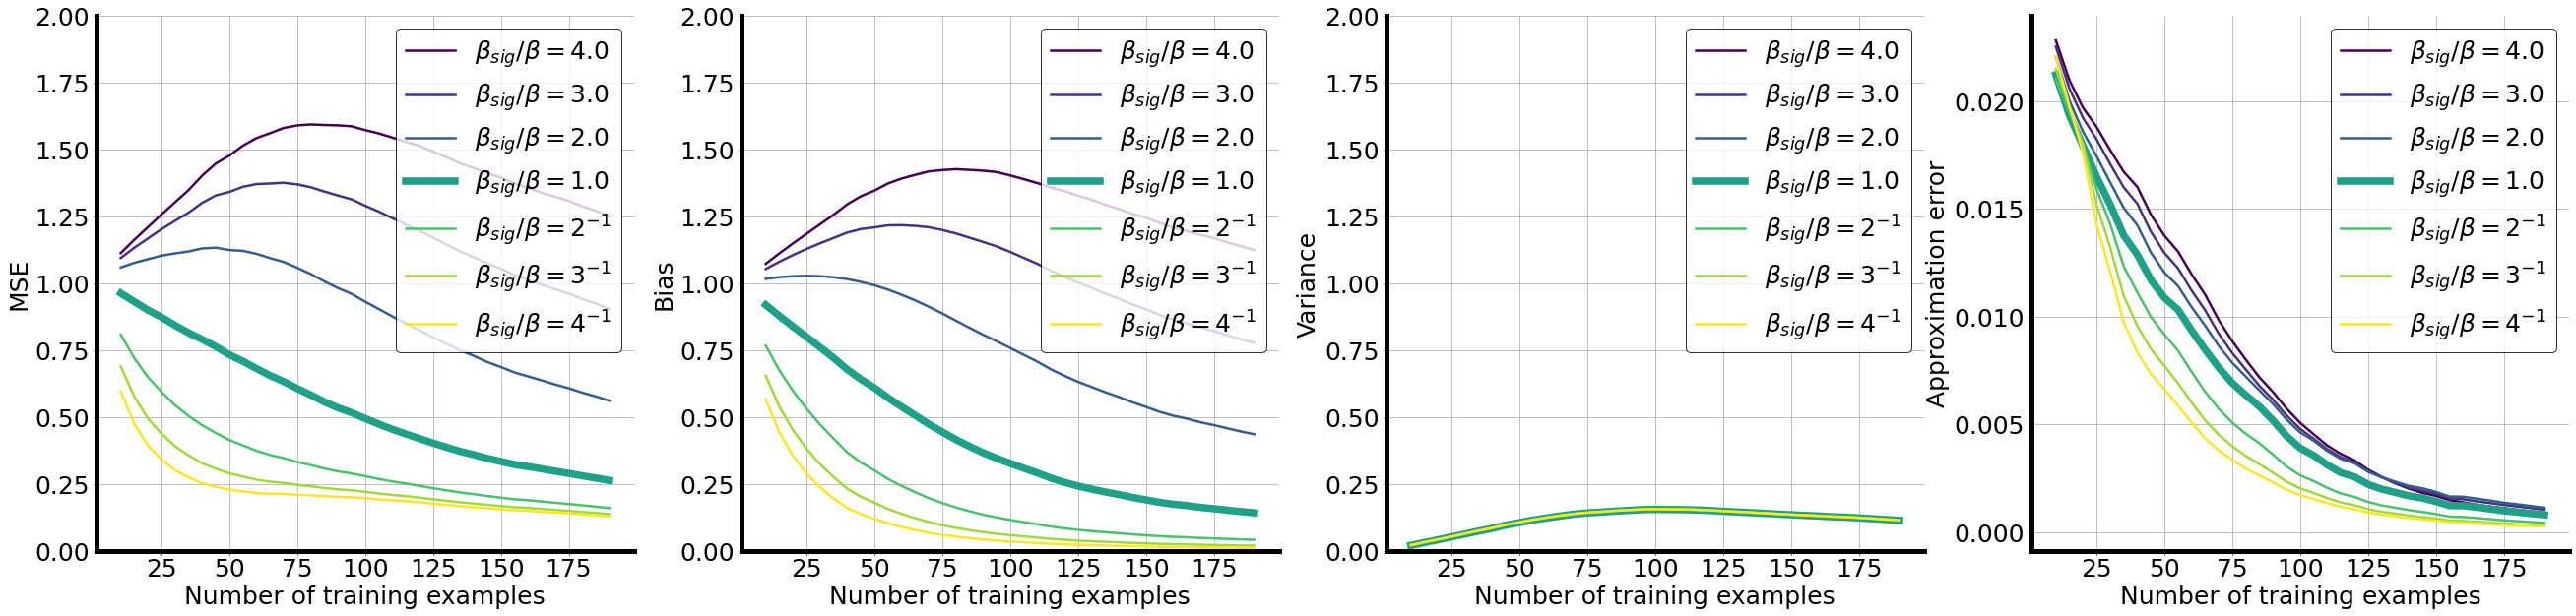

In [76]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)
linewidth = 2.5
y_min = 0; y_max = 2
tick_size = 25
leg_size = 22
x_ax = sample_list
ratio_list_2 = ['$4^{-1}$','$3^{-1}$','$2^{-1}$','1.0','2.0','3.0', '4.0'][::-1]
legendsize=25
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 5

plt.figure(figsize=(45, 10))
ax = plt.subplot(1,4,1)
#plt.plot(x_ax, risk_lse, ls='-',  linewidth=2*linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(ratio_list)):
        lw = linewidth
        ls = '-'
        if l == int(len(ratio_list) / 2):
            lw *= 3
            ls = '-'
        #if l == int(len(ratio_list) / 2):
        #    plt.plot(x_ax, risk_het_crop[i, l, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f")+', uniform mask', linewidth=2*linewidth, c=viridis(l/10))
        #else:
        plt.plot(x_ax, risk_het_crop[i, l, :], label=r'$\beta_{sig}/\beta=$'+ratio_list_2[l], linewidth=lw, c=viridis(l/6), ls=ls)
plt.legend(loc="upper right", prop={'size': leg_size})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('MSE', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
#plt.title("MSE", fontsize=25)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)

ax = plt.subplot(1,4,2)
#plt.plot(x_ax, bias_lse, ls='-',  linewidth=2*linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(ratio_list)):
        lw = linewidth
        ls = '-'
        if l == int(len(ratio_list) / 2):
            lw *= 3
            ls = '-'
        #if l == int(len(ratio_list) / 2):
        #    plt.plot(x_ax, bias_het_crop[i, l, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f")+', uniform mask', linewidth=2*linewidth, c=viridis(l/10))
        #else:
        plt.plot(x_ax, bias_het_crop[i, l, :], label=r'$\beta_{sig}/\beta=$'+ratio_list_2[l], c=viridis(l/6), linewidth=lw, ls=ls)
plt.legend(loc="upper right", prop={'size': leg_size})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('Bias', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
#plt.title("Bias", fontsize=25)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)

ax = plt.subplot(1,4,3)
#plt.plot(x_ax, var_lse, ls='-',  linewidth=2*linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(ratio_list)):
        lw = linewidth
        ls = '-'
        if l == int(len(ratio_list) / 2):
            lw *= 3
            ls = '-'
        #if l == int(len(ratio_list) / 2):
        #    plt.plot(x_ax, var_het_crop[i, l, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f")+', uniform mask', linewidth=2*linewidth, c=viridis(l/10))
        #else:
        plt.plot(x_ax, var_het_crop[i, l, :], label=r'$\beta_{sig}/\beta=$'+ratio_list_2[l], linewidth=lw, c=viridis(l/6), ls=ls)
plt.legend(loc="upper right", prop={'size': leg_size})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('Variance', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
#plt.title("Variance", fontsize=25)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
ax = plt.subplot(1,4,4)
#plt.plot(x_ax, [0] * len(x_ax), ls='-',  linewidth=2*linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    for l in range(len(ratio_list)):
        lw = linewidth
        ls = '-'
        if l == int(len(ratio_list) / 2):
            lw *= 3
            ls = '-'
        #if l == int(len(ratio_list) / 2):
        #    plt.plot(x_ax, err_het_crop[i, l, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f")+', uniform mask', linewidth=2*linewidth, c=viridis(l/10))
        plt.plot(x_ax, err_het_crop[i, l, :], label=r'$\beta_{sig}/\beta=$'+ratio_list_2[l], linewidth=lw, c=viridis(l/6), ls=ls)
#plt.legend(loc="upper right", prop={'size': leg_size})
plt.xlabel('Number of training examples', fontsize=25)
plt.ylabel('Approximation error', fontsize=25)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
#plt.ylim(y_min, y_max)
leg = plt.legend(loc="upper right", prop={'size': legendsize})
leg.get_frame().set_linewidth(1.0)
leg.get_frame().set_edgecolor('black')
#plt.title("Approximation Error", fontsize=25)
plt.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [74]:
ratio_list_2

['4.0', '3.0', '2.0', '1.0', '$2^{-1}$', '$3^{-1}$', '$4^{-1}$']